In [1]:
### based on https://github.com/kylemcdonald/Parametric-t-SNE/blob/master/Parametric%20t-SNE%20(Keras).ipynb

In [2]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [4]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy

### MNIST

In [7]:
dataset = 'mnist'
dims = (28,28,1)

##### load dataset

In [8]:
from tensorflow.keras.datasets import mnist

# load dataset
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
X_train = (train_images / 255.0).astype("float32")
X_test = (test_images / 255.0).astype("float32")
X_train = np.expand_dims(X_train, -1)#((len(X_train), np.product(np.shape(X_train)[1:])))
#X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
#X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat = X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
X_test = X_test.reshape((10000, 28, 28, 1))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


In [9]:
X_train.shape

(50000, 28, 28, 1)

### Model

In [10]:
def Hbeta(D, beta):
    """Computes the Gaussian kernel values given a vector of
    squared Euclidean distances, and the precision of the Gaussian kernel.
    The function also computes the perplexity (P) of the distribution."""
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    H = np.log(sumP) + beta * np.sum(np.multiply(D, P)) / sumP
    P = P / sumP
    return H, P

In [ ]:
def x2p(X, u=15, tol=1e-4, print_iter=500, max_tries=50, verbose=0):
    """
    % X2P Identifies appropriate sigma's to get kk NNs up to some tolerance 
    %
    %   [P, beta] = x2p(xx, kk, tol)
    % 
    % Identifies the required precision (= 1 / variance^2) to obtain a Gaussian
    % kernel with a certain uncertainty for every datapoint. The desired
    % uncertainty can be specified through the perplexity u (default = 15). The
    % desired perplexity is obtained up to some tolerance that can be specified
    % by tol (default = 1e-4).
    % The function returns the final Gaussian kernel in P, as well as the 
    % employed precisions per instance in beta.
    %
    """
    
    # Initialize some variables
    n = X.shape[0]  # number of instances
    P = np.zeros((n, n))  # empty probability matrix
    beta = np.ones(n)  # empty precision vector
    logU = np.log(u)  # log of perplexity (= entropy)

    # Compute pairwise distances
    if verbose > 0:
        print("Computing pairwise distances...")
    sum_X = np.sum(np.square(X), axis=1)
    # note: translating sum_X' from matlab to numpy means using reshape to add a dimension
    D = sum_X + sum_X[:, None] + -2 * X.dot(X.T)

    # Run over all datapoints
    if verbose > 0:
        print("Computing P-values...")
    for i in range(n):

        if verbose > 1 and print_iter and i % print_iter == 0:
            print("Computed P-values {} of {} datapoints...".format(i, n))

        # Set minimum and maximum values for precision
        betamin = float("-inf")
        betamax = float("+inf")

        # Compute the Gaussian kernel and entropy for the current precision
        indices = np.concatenate((np.arange(0, i), np.arange(i + 1, n)))
        Di = D[i, indices]
        H, thisP = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while abs(Hdiff) > tol and tries < max_tries:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i]
                if np.isinf(betamax):
                    beta[i] *= 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i]
                if np.isinf(betamin):
                    beta[i] /= 2
                else:
                    beta[i] = (beta[i] + betamin) / 2

            # Recompute the values
            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, indices] = thisP

    if verbose > 0:
        print("Mean value of sigma: {}".format(np.mean(np.sqrt(1 / beta))))
        print("Minimum value of sigma: {}".format(np.min(np.sqrt(1 / beta))))
        print("Maximum value of sigma: {}".format(np.max(np.sqrt(1 / beta))))

    return P, beta

In [11]:
def compute_joint_probabilities(
    samples, batch_size=5000, d=2, perplexity=30, tol=1e-5, verbose=0
):
    """ This function computes the probababilities in X, split up into batches
    % Gaussians employed in the high-dimensional space have the specified
    % perplexity (default = 30). The number of degrees of freedom of the
    % Student-t distribution may be specified through v (default = d - 1).
    """
    v = d - 1

    # Initialize some variables
    n = samples.shape[0]
    batch_size = min(batch_size, n)

    # Precompute joint probabilities for all batches
    if verbose > 0:
        print("Precomputing P-values...")
    batch_count = int(n / batch_size)
    P = np.zeros((batch_count, batch_size, batch_size))
    # for each batch of data
    for i, start in enumerate(tqdm(range(0, n - batch_size + 1, batch_size))):
        # select batch
        curX = samples[start : start + batch_size]  
        # compute affinities using fixed perplexity
        P[i], beta = x2p(
            curX, perplexity, tol, verbose=verbose
        )  
        # make sure we don't have NaN's
        P[i][np.isnan(P[i])] = 0  
        # make symmetric
        P[i] = P[i] + P[i].T  # / 2
        # obtain estimation of joint probabilities                             
        P[i] = P[i] / P[i].sum()  
        P[i] = np.maximum(P[i], np.finfo(P[i].dtype).eps)

    return P

In [12]:
batch_size = 5000

In [13]:
%time  P = compute_joint_probabilities(X_train_flat, batch_size=batch_size, perplexity = 30, d = n_components, verbose=2)

Precomputing P-values...


Computing pairwise distances...
Computing P-values...
Computed P-values 0 of 5000 datapoints...
Computed P-values 500 of 5000 datapoints...
Computed P-values 1000 of 5000 datapoints...
Computed P-values 1500 of 5000 datapoints...
Computed P-values 2000 of 5000 datapoints...
Computed P-values 2500 of 5000 datapoints...
Computed P-values 3000 of 5000 datapoints...
Computed P-values 3500 of 5000 datapoints...
Computed P-values 4000 of 5000 datapoints...
Computed P-values 4500 of 5000 datapoints...
Mean value of sigma: 2.210395926597027
Minimum value of sigma: 1.1465189822400297
Maximum value of sigma: 3.423562241637291
Computing pairwise distances...
Computing P-values...
Computed P-values 0 of 5000 datapoints...
Computed P-values 500 of 5000 datapoints...
Computed P-values 1000 of 5000 datapoints...
Computed P-values 1500 of 5000 datapoints...
Computed P-values 2000 of 5000 datapoints...
Computed P-values 2500 of 5000 datapoints...
Computed P-values 3000 of 5000 datapoints...
Computed P-

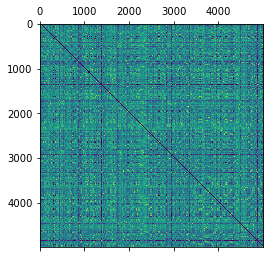

In [30]:
plt.matshow(np.log(P[0]))

In [15]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [16]:
#np.save(DATA_DIR/'P.npy', P)

In [17]:
n = batch_size
d = 2
v = d - 1.0
eps = 10e-15  # needs to be at least 10e-8 to get anything after Q /= K.sum(Q)
# P is the joint probabilities for this batch (Keras loss functions call this y_true)
# activations is the low-dimensional output (Keras loss functions call this y_pred)
def tsne(P, activations):
    """ 
    P is the true 
    """
    sum_act = tf.math.reduce_sum(tf.math.square(activations), axis=1)
    Q = K.reshape(sum_act, [-1, 1]) + -2 * tf.keras.backend.dot(
        activations, tf.transpose(activations)
    )
    Q = (sum_act + Q) / v
    Q = tf.math.pow(1 + Q, -(v + 1) / 2)
    Q *= 1 - np.eye(n)
    Q /= tf.math.reduce_sum(Q)
    Q = tf.math.maximum(Q, eps)
    C = tf.math.log((P + eps) / (Q + eps))
    C = tf.math.reduce_sum(P * C)
    return C

### Train model

In [18]:
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(X_train_flat.shape[1],)))
model.add(Dense(500, activation='relu'))
model.add(Dense(2000, activation='relu'))
model.add(Dense(2))

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=2),
])

In [20]:
sgd = tf.keras.optimizers.Adam(lr=0.01)

In [21]:
%time model.compile(loss=tsne, optimizer=sgd)

CPU times: user 87.1 ms, sys: 140 ms, total: 227 ms
Wall time: 227 ms


In [22]:
# Joint probabilities of data
Y_train_tsne = P.reshape(X_train.shape[0], -1)

In [31]:
Y_train_tsne.shape

(50000, 5000)

In [24]:
history = model.fit(X_train, Y_train_tsne, batch_size=batch_size, shuffle=False, nb_epoch=1000)

W0719 21:01:09.390985 139919301691200 training.py:792] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 50000 samples
Epoch 1/1000
50000/50000 [==============================] - 9s 179us/sample - loss: 3.7655
Epoch 2/1000
50000/50000 [==============================] - 1s 14us/sample - loss: 3.0591
Epoch 3/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 2.7597
Epoch 4/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 2.5616
Epoch 5/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 2.4592
Epoch 6/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 2.3615
Epoch 7/1000
50000/50000 [==============================] - 1s 14us/sample - loss: 2.2969
Epoch 8/1000
50000/50000 [==============================] - 1s 14us/sample - loss: 2.2548
Epoch 9/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 2.2192
Epoch 10/1000
50000/50000 [==============================] - 1s 14us/sample - loss: 2.1870
Epoch 11/1000
50000/50000 [==============================] - 1s 15us/sample

50000/50000 [==============================] - 1s 17us/sample - loss: 1.6089
Epoch 180/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.6101
Epoch 181/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.6088
Epoch 182/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.6114
Epoch 183/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.6056
Epoch 184/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.6120
Epoch 185/1000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.6138
Epoch 186/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.6122
Epoch 187/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.6198
Epoch 188/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.6208
Epoch 189/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.6392
Epo

50000/50000 [==============================] - 1s 15us/sample - loss: 1.5276
Epoch 358/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.5320
Epoch 359/1000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.5272
Epoch 360/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.5279
Epoch 361/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.5317
Epoch 362/1000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.5266
Epoch 363/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.5211
Epoch 364/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.5191
Epoch 365/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.5233
Epoch 366/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.5169
Epoch 367/1000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.5133
Epo

50000/50000 [==============================] - 1s 14us/sample - loss: 1.4789
Epoch 536/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4813
Epoch 537/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4800
Epoch 538/1000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.4768
Epoch 539/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4808
Epoch 540/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4830
Epoch 541/1000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.4838
Epoch 542/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4862
Epoch 543/1000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.4925
Epoch 544/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4946
Epoch 545/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4952
Epo

50000/50000 [==============================] - 1s 15us/sample - loss: 1.4601
Epoch 714/1000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.4605
Epoch 715/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4602
Epoch 716/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4633
Epoch 717/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4630
Epoch 718/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4648
Epoch 719/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4643
Epoch 720/1000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.4617
Epoch 721/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4590
Epoch 722/1000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.4569
Epoch 723/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4553
Epo

50000/50000 [==============================] - 1s 15us/sample - loss: 1.4553
Epoch 892/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4558
Epoch 893/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4535
Epoch 894/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4541
Epoch 895/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4579
Epoch 896/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4576
Epoch 897/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4555
Epoch 898/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4552
Epoch 899/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4553
Epoch 900/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4532
Epoch 901/1000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.4487
Epo

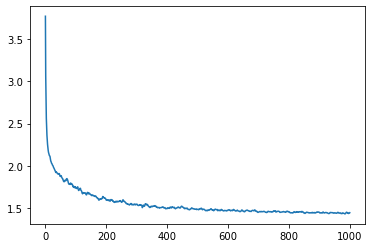

In [25]:
plt.plot(history.history['loss'])

In [26]:
z = model.predict(X_train)

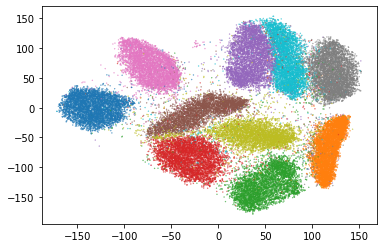

In [27]:
plt.scatter(z[:,0], z[:,1], s=.1, c = Y_train, cmap = plt.cm.tab10)